In [2]:
####################################################################
#                     Practica No.3
# Pregunta 1
####################################################################

#Descomentar para instalar los paquetes
#install.packages("R2WinBUGS")
#install.packages("mcmcplots")

library(R2WinBUGS)
library(coda)
library(boot)
library(mcmcplots)

Warning message:
"package 'R2WinBUGS' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Loading required package: boot
Warning message:
"package 'mcmcplots' was built under R version 3.4.4"

In [3]:
#Directorio de WinBUGS
WINBUGS.DIR <- "D:/bin/WinBUGS14/"

#Nombre de archivo
NAME.FILE.MOD1.BUG <- "Practica-03-mod1.bug"
NAME.FILE.MOD2.BUG <- "Practica-03-mod2.bug"
NAME.FILE.MOD3.BUG <- "Practica-03-mod3.bug"

#Ruta archivo
PATH.FILE <- "https://raw.githubusercontent.com/jgomezz/MscEstadisticaAplicada-UNALM-2018-2/master/MLG/Practica-03/molinos.csv"

In [4]:
#Lectura de datos
molinos.data <- read.csv(PATH.FILE, header = TRUE)
head(molinos.data)

viento,corriente
5.0,1.582
6.0,1.822
3.4,1.057
2.7,0.500
10.0,2.236
9.7,2.386


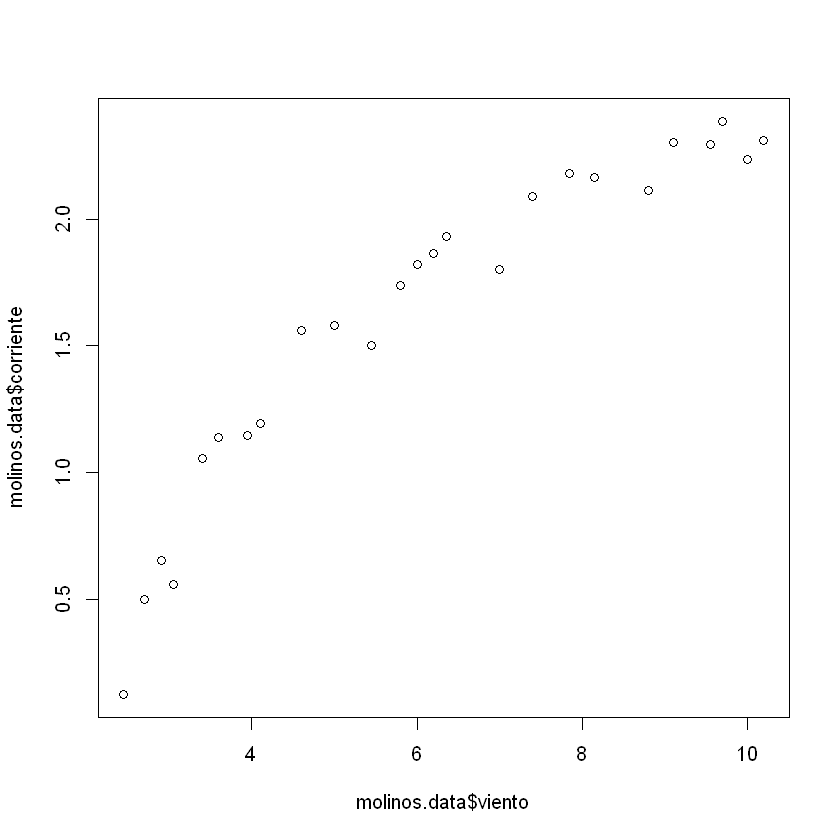

In [5]:
#Análisis descriptivo
plot(molinos.data$viento, molinos.data$corriente)

In [7]:
#Datos para el análisis
molinos.data.bugs <- list(viento = molinos.data$viento ,
                          corriente = molinos.data$corriente ,
                          N = nrow(molinos.data))

# Parametros
molinos.param.bugs <- c("alpha","beta1","tau","sigma2")


# Inicializa : asigna valores aleatorios para inicializarlos
molinos.inits.bugs <- function() {
                          list( alpha = rnorm(1), 
                                beta1 = rnorm(1), 
                                tau   = rgamma(1,1,1) )}        

In [8]:
####################################################################
# MODELO LINEAL NORMAL :  Modelo 1: Eta_i= Beta_0 + Beta_1*x_i
####################################################################

# Inferencia Clásica
molinos.model.1.clasic<-lm(molinos.data$corriente ~ molinos.data$viento)
summary(molinos.model.1.clasic)


Call:
lm(formula = molinos.data$corriente ~ molinos.data$viento)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59869 -0.14099  0.06059  0.17262  0.32184 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.13088    0.12599   1.039     0.31    
molinos.data$viento  0.24115    0.01905  12.659 7.55e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2361 on 23 degrees of freedom
Multiple R-squared:  0.8745,	Adjusted R-squared:  0.869 
F-statistic: 160.3 on 1 and 23 DF,  p-value: 7.546e-12


In [9]:
# Aplicando Bayesianos
molinos.model.1.bugs <- function(){
  # verosimilitud
  for (i in 1:N) {
    mu[i] <- alpha + beta1*viento[i];
    corriente[i] ~ dnorm(mu[i],tau);
  }
  # Las priori : estoy usando priori no informativos 
  # porque le estoy dando un rango amplio ( 0.0 en casi todos los modelos)
  alpha ~ dnorm(0.0,1.0E-4);      # 1er parametro  
  beta1 ~ dnorm(0.0,1.0E-4);      # 2do parametro
  tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 

  # con valores pequeño para tener una varianza grande
  sigma2 <- 1/tau;
}

# Grabar archivo
write.model(molinos.model.1.bugs, NAME.FILE.MOD1.BUG)

# Inferencia Bayesiana
molinos.fit.model.1.bugs <- bugs(data = molinos.data.bugs,
                                 inits =  molinos.inits.bugs,
                                 parameters.to.save =  molinos.param.bugs,
                                 model.file= NAME.FILE.MOD1.BUG,
                                 n.chains=2, 
                                 n.iter=20000,
                                 n.burnin=10000,
                                 n.thin=1,
                                 bugs.directory=WINBUGS.DIR,
                                 clearWD=TRUE, 
                                 debug=FALSE)

In [10]:
#Mostrar resultados de la simulación
print(molinos.fit.model.1.bugs,4)

Inference for Bugs model at "Practica-03-mod1.bug", fit using WinBUGS,
 2 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 20000 iterations saved
            mean     sd    2.5%     25%     50%     75%   97.5%   Rhat n.eff
alpha     0.1328 0.1314 -0.1290  0.0462  0.1330  0.2189  0.3925 1.0010 20000
beta1     0.2409 0.0198  0.2024  0.2278  0.2409  0.2540  0.2803 1.0010 20000
tau      17.8848 5.2740  9.1159 14.0900 17.3850 21.0900 29.6200 1.0010 20000
sigma2    0.0612 0.0197  0.0338  0.0474  0.0575  0.0710  0.1097 1.0010 20000
deviance -0.1616 2.5452 -3.0860 -2.0360 -0.7978  1.0192  6.4210 1.0011 14000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = Dbar-Dhat)
pD = 3.1 and DIC = 2.9
DIC is an estimate of expected predictive error (lower deviance is better).


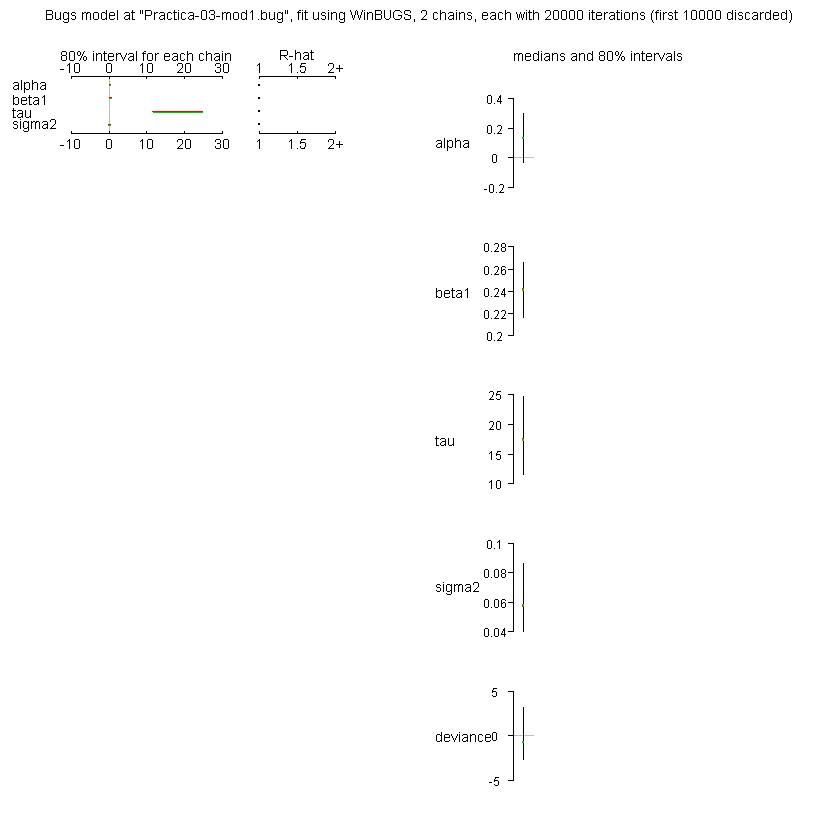

In [11]:
#Diagnostico de Convergencia
plot(molinos.fit.model.1.bugs)

In [9]:
#Mostrar resultado por navegador de trace, density, autocorrelation
mcmcplot(molinos.fit.model.1.bugs)

In [12]:
####################################################################
# Modelo Lineal Normal - Modelo 2 : Eta_i= Beta_0 + Beta_1*1/x_i
####################################################################

# Inferencia Clásica -
molinos.model.2.clasic<-lm(molinos.data$corriente ~ I(1/molinos.data$viento))
summary(molinos.model.2.clasic)


Call:
lm(formula = molinos.data$corriente ~ I(1/molinos.data$viento))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20547 -0.04940  0.01100  0.08352  0.12204 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                2.9789     0.0449   66.34   <2e-16 ***
I(1/molinos.data$viento)  -6.9345     0.2064  -33.59   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09417 on 23 degrees of freedom
Multiple R-squared:   0.98,	Adjusted R-squared:  0.9792 
F-statistic:  1128 on 1 and 23 DF,  p-value: < 2.2e-16


In [13]:
# Aplicando Bayesianos
molinos.model.2.bugs <- function(){
  # verosimilitud
  for (i in 1:N) {
    mu[i] <- alpha + beta1*(1/viento[i]);
    corriente[i] ~ dnorm(mu[i],tau);
  }
  # Las priori : estoy usando priori no informativos 
  # porque le estoy dando un rango amplio ( 0.0 en casi todos los modelos)
  alpha ~ dnorm(0.0,1.0E-4);      # 1er parametro  
  beta1 ~ dnorm(0.0,1.0E-4);      # 2do parametro
  tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 
  
  # con valores pequeño para tener una varianza grande
  sigma2 <- 1/tau;
}

# Grabar archivo
write.model(molinos.model.2.bugs, NAME.FILE.MOD2.BUG)

# Inferencia Bayesiana
molinos.fit.model.2.bugs <- bugs(data = molinos.data.bugs,
                                 inits =  molinos.inits.bugs,
                                 parameters.to.save =  molinos.param.bugs,
                                 model.file= NAME.FILE.MOD2.BUG,
                                 n.chains=2, 
                                 n.iter=20000,
                                 n.burnin=10000,
                                 n.thin=1,
                                 bugs.directory=WINBUGS.DIR,
                                 clearWD=TRUE, 
                                 debug=FALSE)

In [14]:
#Mostrar resultados de la simulación
print(molinos.fit.model.2.bugs,4)

Inference for Bugs model at "Practica-03-mod2.bug", fit using WinBUGS,
 2 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 20000 iterations saved
             mean      sd     2.5%      25%      50%      75%    97.5%   Rhat
alpha      2.9796  0.0470   2.8850   2.9490   2.9800   3.0100   3.0720 1.0010
beta1     -6.9376  0.2158  -7.3560  -7.0800  -6.9380  -6.7950  -6.5080 1.0010
tau      111.4552 32.8664  56.8095  87.7800 108.3000 131.4000 184.6000 1.0010
sigma2     0.0098  0.0032   0.0054   0.0076   0.0092   0.0114   0.0176 1.0010
deviance -46.0906  2.5581 -49.0300 -47.9725 -46.7300 -44.9100 -39.4700 1.0011
         n.eff
alpha    20000
beta1    20000
tau      20000
sigma2   20000
deviance 14000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = Dbar-Dhat)
pD = 3.1 and DIC = -43.0
DIC is an estimate of expected predictive error (lower devian

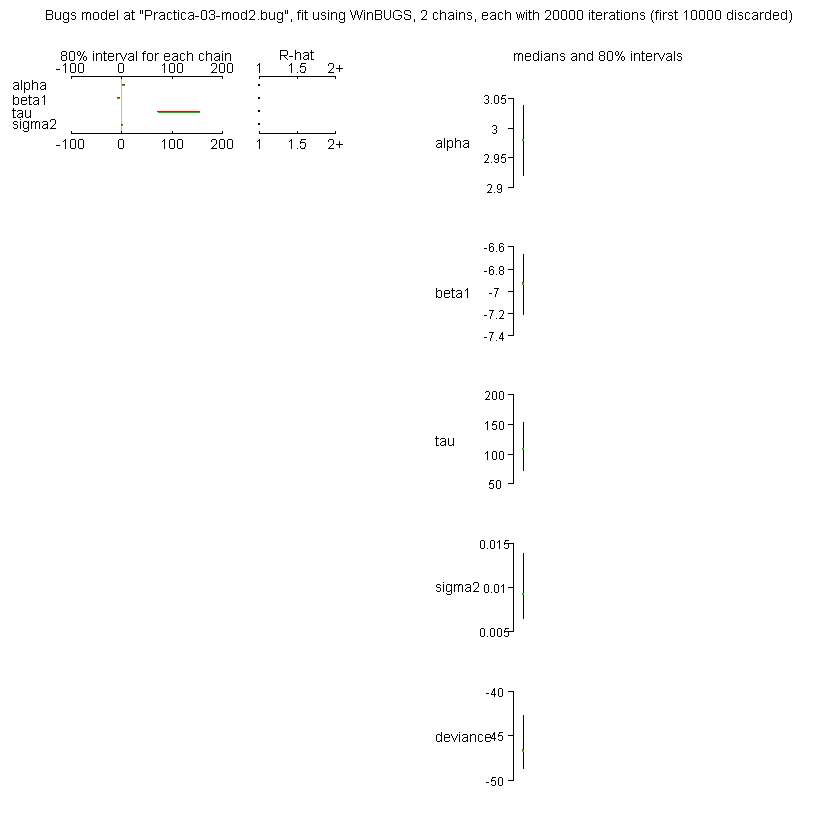

In [15]:
#Diagnostico de Convergencia
plot(molinos.fit.model.2.bugs)

In [14]:
#Mostrar resultado por navegador de trace, density, autocorrelation
mcmcplot(molinos.fit.model.2.bugs)

In [16]:
####################################################################
# Modelo Lineal Normal - Modelo 3 : Eta_i= Beta_0 + Beta_1*log(x_i)
####################################################################

# Inferencia Clásica -
molinos.model.3.clasic<-lm(molinos.data$corriente ~ I(log(molinos.data$viento)))
summary(molinos.model.3.clasic)


Call:
lm(formula = molinos.data$corriente ~ I(log(molinos.data$viento)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31619 -0.07685  0.02395  0.11139  0.23029 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.83036    0.11083  -7.493  1.3e-07 ***
I(log(molinos.data$viento))  1.41677    0.06234  22.728  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1376 on 23 degrees of freedom
Multiple R-squared:  0.9574,	Adjusted R-squared:  0.9555 
F-statistic: 516.6 on 1 and 23 DF,  p-value: < 2.2e-16


In [17]:
# Aplicando Bayesianos
molinos.model.3.bugs <- function(){
  # verosimilitud
  for (i in 1:N) {
    mu[i] <- alpha + beta1*log(viento[i]);
    corriente[i] ~ dnorm(mu[i],tau);
  }
  # Las priori : estoy usando priori no informativos 
  # porque le estoy dando un rango amplio ( 0.0 en casi todos los modelos)
  alpha ~ dnorm(0.0,1.0E-4);      # 1er parametro  
  beta1 ~ dnorm(0.0,1.0E-4);      # 2do parametro
  tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 
  
  # con valores pequeño para tener una varianza grande
  sigma2 <- 1/tau;
}

# Grabar archivo
write.model(molinos.model.3.bugs, NAME.FILE.MOD3.BUG)

# Inferencia Bayesiana
molinos.fit.model.3.bugs <- bugs(data = molinos.data.bugs,
                                 inits =  molinos.inits.bugs,
                                 parameters.to.save =  molinos.param.bugs,
                                 model.file= NAME.FILE.MOD3.BUG,
                                 n.chains=2, 
                                 n.iter=20000,
                                 n.burnin=10000,
                                 n.thin=1,
                                 bugs.directory=WINBUGS.DIR,
                                 clearWD=TRUE, 
                                 debug=FALSE)

In [18]:
#Mostrar resultados de la simulación
print(molinos.fit.model.3.bugs,4)

Inference for Bugs model at "Practica-03-mod3.bug", fit using WinBUGS,
 2 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 20000 iterations saved
             mean      sd     2.5%      25%      50%      75%    97.5%   Rhat
alpha     -0.8286  0.1157  -1.0590  -0.9046  -0.8284  -0.7523  -0.6008 1.0010
beta1      1.4158  0.0650   1.2900   1.3730   1.4160   1.4590   1.5450 1.0010
tau       52.4982 15.4810  26.7597  41.3500  51.0300  61.9000  86.9502 1.0010
sigma2     0.0208  0.0067   0.0115   0.0162   0.0196   0.0242   0.0374 1.0010
deviance -27.1516  2.5498 -30.0800 -29.0300 -27.7900 -25.9700 -20.5500 1.0011
         n.eff
alpha    20000
beta1    20000
tau      20000
sigma2   20000
deviance 14000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = Dbar-Dhat)
pD = 3.1 and DIC = -24.1
DIC is an estimate of expected predictive error (lower devian

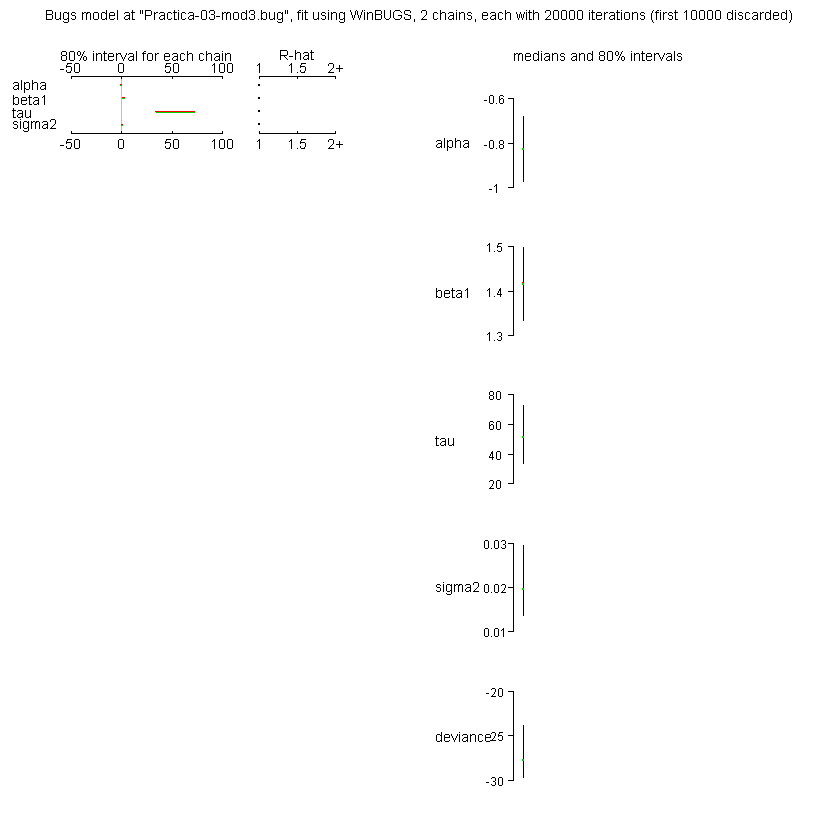

In [19]:
#Diagnostico de Convergencia
plot(molinos.fit.model.3.bugs)

In [21]:
#Mostrar resultado por navegador de trace, density, autocorrelation
mcmcplot(molinos.fit.model.3.bugs)

In [22]:
# Comparación de los modelos basados en el DIC : Deviance Information Criterion
df <- data.frame(
          modelo = c(" Modelo 1", 
                     " Modelo 2", 
                     " Modelo 3"),
          DIC = c(molinos.fit.model.1.bugs$DIC,
                  molinos.fit.model.2.bugs$DIC,
                  molinos.fit.model.3.bugs$DIC)
          )

df[order(df$DIC),]

,modelo,DIC
2,Modelo 2,-43.021
3,Modelo 3,-24.082
1,Modelo 1,2.908
